In [53]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import konlpy
from konlpy.tag import Twitter
from collections import Counter
import pickle 
from tqdm import tnrange
from tqdm import tqdm

## 01. File Loading

In [54]:
with open('essay_df_2.pkl', 'rb') as f:
    essay_df = pickle.load(f)

In [55]:
essay_df.head(1)

,company_id,company,year,season,experience,position,score,feedback,content,views,position_broad
0,0,농협은행(주),2020,상반기,신입,사무·총무·법무,2.0,전반적으로 호감을 주지 못하는 내용 성실히 쓰려고 노력한 점 질문의 의도에 맞지 ...,직장은 생계를 꾸려나가는 수단이기도 하지만 저의 가치관을 실현시킬 수 있는 곳이라고...,"15,387",경영·사무


In [56]:
# [company] contents
with open('content_list_2.pkl', 'rb') as f:
    content_list = pickle.load(f)
    
# # [company] word_sorted_counted
# sorted_counter_list = []  
# with open('sorted_counter_list_2.pkl', 'rb') as f:
#     sorted_counter_list = pickle.load(f)

#[company] word_dic --countered
with open('counter_list_2.pkl', 'rb') as f:
    counter_list = pickle.load(f)
    
# [postion] job_counter(sorted)_list
with open('position_counter_list.pkl', 'rb') as f:
    job_counter_list = pickle.load(f)

#[position] job_code_dic
with open('position_code_dic.pkl', 'rb') as f:
    job_code_dic = pickle.load(f)
    
#[company] company_code_dic
with open('company_code_dict.pkl', 'rb') as f:
    company_code_dict = pickle.load(f)

In [57]:
#불용어 처리
del_words = ['생각', '통해', '위해', '업무','경험', '대한', '노력', '회사', '배우다', '결과', '다양하다',
             '직무', '크다','가장', '받다', '분야', '과정', '이르다', '다양하다', '수행', '전공', '맡다',
             '모비스', '이루다', '영업', '시작', '오다', '필요하다', '새롭다', '현대', '인턴', '현장',
             '나가다', '관련', '시장', '해보다', '산업', '역할', '발전', '가다', '사업', '모비스', '부서',
             '직접', '입사', '상황', '영업', '동아리', '갖추다', '사용', '통해', '위해', '만들다', '받다',
             '이르다', '이러하다', '얻다', '가다', '대해', '중요하다', '필요하다', '대한', '배우다', '많다',
             '다양하다', '새롭다', '들다', '맡다', '오다', '늘다', '이루다', '통해', '위해', '많다',
             '이러하다', '필요하다', '얻다', '오다', '크다', '가지', '대한', '이르다', '느끼다', '많다',
             '해주다', '모든', '내다', '맡다', '들다', '나가다', '가다', '가지다', '받다', '만들다',
             '배우다', '해주다', '따르다', '이루다', '주다', '내다', '여러', '생각', '받다', '만들다',
             '배우다', '키우다', '많다', '통해', '위해', '대한', '이르다', '새롭다', '크다', '이러하다',
             '느끼다', '들다', '필요하다', '얻다', '중요하다', '가다', '맡다', '이루다', '이러하다', '다양하다',
             '필요하다', '오다', '해보다', '가장', '해주다', '가다' , '크다', '전기','이르다', '가지',
             '이러하다', '대해', '필요하다', '가장', '크다', '바탕', '오다', '들다', 
             '농협', '삼성', 'GS', 'KT', '롯데', '한국전력공사', '한화', 'CJ', 'LG', 'SK']

del_words_set = set(del_words)
stopwords = pd.read_json('stopwords-ko.json')
stopwords_list = list(stopwords[0])
common_del_list = ['되어다','때문','그리고','좋다','자다','없다','같다','싶다','보다', '하다', '있다', '되다', '이다', '돼다', '않다', '그렇다', '아니다', '이렇다', '그렇다', '어떻다']
del_list = stopwords_list + common_del_list + list(del_words_set)

def counter(contents): 
    
    twitter = Twitter()
    raw_pos_tagged = twitter.pos(contents, norm=True, stem=True) 
 
    word_cleaned = []
    
    for word, tag in raw_pos_tagged: 
        if not tag in ["Josa", "Eomi", "Punctuation", "Foreign"]: 
            if (len(word) != 1) & (word not in del_list): 
                word_cleaned.append(word)

    word_counted = Counter(word_cleaned)
    word_dic = dict(word_counted)
    return word_dic


## 02-1. 기업간 TF-IDF, Cosine Similarity

In [58]:
'''
1) company
- tf_idf_1 ; 2개 회사간 코사인 유사도
- tf_idf ; 5개 회사간 전체/30개/단어 코사인 유사도 (heatmap)
2) job(position)
- tf_idf_job ; 5개 직무간 단어 코사인 유사도
'''

'\n1) company\n- tf_idf_1 ; 2개 회사간 코사인 유사도\n- tf_idf ; 5개 회사간 전체/30개/단어 코사인 유사도 (heatmap)\n2) job(position)\n- tf_idf_job ; 5개 직무간 단어 코사인 유사도\n'

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
#ver1: tf_idf between 2 company
def tf_idf_1(a,b,contents=content_list):
    corpus = [contents[a], contents[b]]
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus).todense()
    print("Similarity between {} and {}: ".format(a,b), cosine_similarity(X[0], X[1]))

In [61]:
tf_idf_1(1,2) #불용어 처리 X

Similarity between 1 and 2:  [[0.91424163]]


In [62]:
'''job/company counter의 단어만 수집(list)'''
 # ['농협단어들','롯데단어들',...] #['경영사무직..','...단어들..']
def de_counter(countered): #para ; [농협dict, 롯데dict,..]
    token_list =[]
    words =''
    try: #단일 회사 리스트 [농협dict]
        for i in tqdm(range(len(countered.keys()))):
            words += list(countered.keys())[i]+' '
        token_list.append(words)
    except:#여러 회사 리스트 [농협 dict, 롯데 dict,..]
        for i in range(len(countered)):
            words = ''.join(de_counter(countered[i]))
            token_list.append(words)
    return token_list

In [63]:
job_words=de_counter(job_counter_list)
job_words[0][:16]

100%|██████████| 2049/2049 [00:00<00:00, 12282.54it/s]


'직장 생계 꾸리다 수단 가치관'

In [64]:
'''random selecting of contents'''
import random
#get random content[:30] #return string
def selecting30(company_code): #불용어 처리 O
    selected_contents =[]
    sampling = random.choices(list(essay_df.content[essay_df['company_id']==company_code].index), k=30)
#     print(sampling)
    contents=''
    for idx in sampling:
        contents += essay_df.content[idx]
    return ''.join(de_counter(counter(contents))) #make all list values to one string

In [65]:
'''
ver2: tf_idf between several companies
1)'n'; about all content -- contents_list
2)'y'; about selected(30) contents(countered) --by selecting30
'''
def get_titles(codes):
    titles=[]
    for i in range(len(codes)):
        titles.append(company_code_dict[i])
    return titles

import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
import seaborn as sns

#tf_idf between several companies
def tf_idf(contents=content_list[2:]):
    codes=[]
    corpus=[]

    print(company_code_dict)
    codes = list(map(int,input("plz enter company codes (5): ").split(" ")))
    titles=get_titles(codes)
    selecting = str(input("you want limited contents? : (y/n)").lower())
    
    if len(codes) != 5:
        return print("ERROR: plz enter 5 of them!")
    else:
        length = 5
           
    for i in tqdm(range(length)):
        if codes[i] in company_code_dict.keys():
            if selecting == 'y':
                corpus.append(selecting30(i))
            else:
                corpus.append(contents[i])
        else:
            return print("ERROR: codes are out of range!")

    vectorizer = TfidfVectorizer(stop_words='english') #stop_words='english'
    X = vectorizer.fit_transform(corpus).todense()
    similarity = cosine_similarity(X,X)
    sns.heatmap(similarity,xticklabels=titles, yticklabels=titles,
                annot=True,cmap='viridis',linewidths=.5)
    plt.show()

{0: '농협', 1: '롯데', 2: '삼성', 3: '한국전력공사', 4: '한화', 5: '현대자동차', 6: 'CJ', 7: 'GS', 8: 'KT', 9: 'LG', 10: 'SK'}
plz enter company codes (5): 0 1 2 3 4
you want limited contents? : (y/n)n


100%|██████████| 5/5 [00:00<00:00, 19454.10it/s]


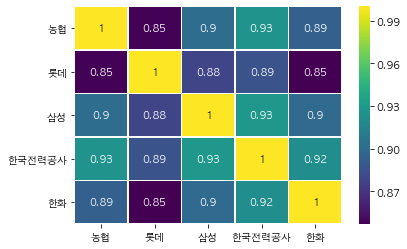

In [66]:
#1) result of original contents -- 불용어 처리 X
tf_idf()

100%|██████████| 12230/12230 [00:02<00:00, 4725.82it/s]


{0: '농협', 1: '롯데', 2: '삼성', 3: '한국전력공사', 4: '한화', 5: '현대자동차', 6: 'CJ', 7: 'GS', 8: 'KT', 9: 'LG', 10: 'SK'}
plz enter company codes (5): 0 1 2 3 4
you want limited contents? : (y/n)n


100%|██████████| 5/5 [00:00<00:00, 43062.67it/s]


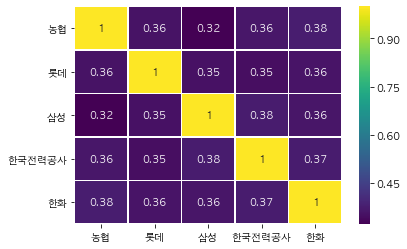

In [67]:
#2)result of words_countered(from contents)
tf_idf(de_counter(counter_list[2:]))

{0: '농협', 1: '롯데', 2: '삼성', 3: '한국전력공사', 4: '한화', 5: '현대자동차', 6: 'CJ', 7: 'GS', 8: 'KT', 9: 'LG', 10: 'SK'}
plz enter company codes (5): 0 1 2 3 4
you want limited contents? : (y/n)y


  0%|          | 0/5 [00:00<?, ?it/s]/Users/ongi/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')

 20%|██        | 1/5 [00:11<00:45, 11.33s/it]/Users/ongi/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')

 40%|████      | 2/5 [00:20<00:31, 10.35s/it]/Users/ongi/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')

 60%|██████    | 3/5 [00:30<00:20, 10.03s/it]/Users/ongi/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')

 80%|████████  | 4/5 [00

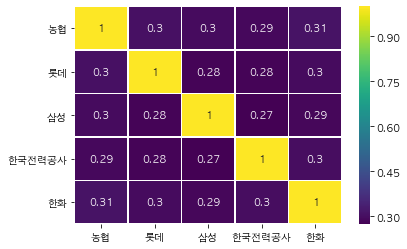

In [68]:
#3)result of selected contentes(;countered)
tf_idf()

- 결과값 확인

In [48]:
#'농협'의 자소서 3개 추출 -- 빈도분석 후 단어 ; result1
temp1 = random.choices(list(essay_df.content[essay_df['company_id']==0].index), k=3)
contents=''
for idx in temp1:
    contents += essay_df.content[idx]
result1 = ''.join(de_counter(counter(contents)))
#'롯데'의 자소서 3개 추출 -- 빈도분석 후 단어 : result2
temp2 = random.choices(list(essay_df.content[essay_df['company_id']==1].index), k=3)
contents=''
for idx in temp2:
    contents += essay_df.content[idx]
result2 = ''.join(de_counter(counter(contents)))

temp_content =[result1,result2]
tf_idf_1(0,1,temp_content) #두 회사간 빈도분석(0;농협, 1;롯데)

/Users/ongi/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
100%|██████████| 698/698 [00:00<00:00, 104925.25it/s]
/Users/ongi/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
100%|██████████| 700/700 [00:00<00:00, 101983.84it/s]

Similarity between 0 and 1:  [[0.16853772]]


## 02-2. 직무간 TF-IDF, Cosine Similarity

In [51]:
def get_job_titles(codes):
    titles=[]
    for i in range(len(codes)):
        titles.append(job_code_dic[i]) #job_code_dic
    return titles

import matplotlib.pyplot as plt
# plt.rc('font', family='AppleGothic')
import seaborn as sns

#tf_idf between jobs
def tf_idf_job(contents):
    codes=[]
    corpus=[]

    print(job_code_dic)
    codes = list(map(int,input("plz enter job codes (5): ").split(" ")))
    titles=get_job_titles(codes)
    
    if len(codes) != 5:
        return print("ERROR: plz enter 5 of them!")
    else:
        length = 5
           
    for i in tqdm(range(length)):
        if codes[i] in job_code_dic.keys():
            corpus.append(contents[i])
        else:
            return print("ERROR: codes are out of range!")

    vectorizer = TfidfVectorizer(stop_words='english') #stop_words='english'
    X = vectorizer.fit_transform(corpus).todense()
    similarity = cosine_similarity(X,X)
    sns.heatmap(similarity,xticklabels=titles, yticklabels=titles,
                annot=True,cmap='viridis',linewidths=.5)
    plt.show()

100%|██████████| 2049/2049 [00:00<00:00, 19383.96it/s]


{0: '경영·사무', 1: '마케팅·광고·홍보', 2: 'IT·인터넷', 3: '디자인', 4: '무역·유통', 5: '영업·고객상담', 6: '서비스', 7: '연구개발·설계', 8: '생산·제조', 9: '교육', 10: '건설', 11: '의료', 12: '미디어', 13: '전문·특수직'}
plz enter job codes (5): 0 1 2 3 4


100%|██████████| 5/5 [00:00<00:00, 20661.60it/s]


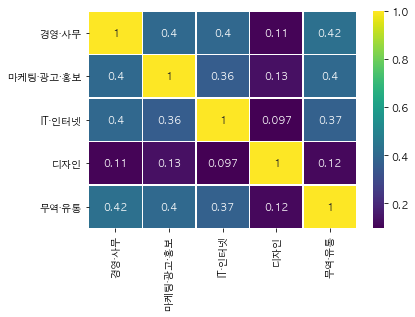

In [52]:
#result of 
tf_idf_job(de_counter(job_counter_list))